In [21]:
%load_ext autoreload
%autoreload 2

from primitives.primitives import *
from primitives.tv_model import *
from cirq import Circuit, LineQid, measure, sample, Simulator
import matplotlib.pyplot as plt
from numpy.linalg import eig
import json
from scipy.constants import hbar

simulator = Simulator()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evolving a state

In [7]:
def evolve(qudits, temps, initial, T, V):

    if len(temps) > 1:
        evolution_number = evolve_gate(DoubleNumberGate)(C=V, t = temps[1]-temps[0])
        evolution_horizontal_hop = evolve_gate(HopXGate)(C=T, t = (temps[1]-temps[0])/2)
        evolution_vertical_hop = evolve_gate(HopYGate)(C=T, t = (temps[1]-temps[0])/2)
    rows, cols = qudits.shape
    results = []
    evolution_circuit = []
    for idx, t in enumerate(temps):
        print(f"Temp: {t}")
        if t != 0:    
            # Hopping part
            for row in range(rows):
                for col in range(cols):
                    # horizontal interaction
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_horizontal_hop(a, b))
                    # vertical interaction
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_vertical_hop(a, b))

            # On-site part
            for row in range(rows):
                for col in range(cols):
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_number(a, b))
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_number(a, b))
            # Hopping part
            for row in range(rows):
                for col in range(cols):
                    # horizontal interaction
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_horizontal_hop(a, b))
                    # vertical interaction
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_vertical_hop(a, b))

        circuit = Circuit([*initial, *evolution_circuit])
        results.append((circuit, simulator.simulate(circuit)))
            
    return results

## Evolving a 4x2 lattice

In [8]:
T = -1
V = 0.5

rows = 2
columns = 3
qudits = np.array(LineQid.range(rows * columns, dimension=4)).reshape(rows, columns)


In [9]:
coeffs = [1, 1]

In [10]:
plaquettes = generate_plaquette_constraints(qudits)

# initial circuit that ensures that the correct subspace is used (really?)

projected_subspace = [Project_Constraint()(*pl) for pl in plaquettes]
initial_state = [
    #AddPlaqPair(*coeffs)(qudits[0][0], qudits[0][1], qudits[1][1], qudits[1][0])
    AddTriple(*coeffs)(qudits[0][0], qudits[0][1], qudits[0][2]),
    #AddHorizontalPair()(qudits[0][0], qudits[0][1]),
    #AddVerticalPair()(qudits[0][0], qudits[1][0]),
]
initial_circuit = [*projected_subspace, *initial_state]

In [36]:
final_T = 5
num_steps = 100
dt = final_T / num_steps

temps = np.arange(0, final_T+dt/2, dt)


# results is a list of tuples, every tuple contains the circuit and the result shots
results = evolve(qudits, temps, initial_circuit, T=T, V=V)

Temp: 0.0
Temp: 0.05
Temp: 0.1
Temp: 0.15000000000000002
Temp: 0.2
Temp: 0.25
Temp: 0.30000000000000004
Temp: 0.35000000000000003
Temp: 0.4
Temp: 0.45
Temp: 0.5
Temp: 0.55
Temp: 0.6000000000000001
Temp: 0.65
Temp: 0.7000000000000001
Temp: 0.75
Temp: 0.8
Temp: 0.8500000000000001
Temp: 0.9
Temp: 0.9500000000000001
Temp: 1.0
Temp: 1.05
Temp: 1.1
Temp: 1.1500000000000001
Temp: 1.2000000000000002
Temp: 1.25
Temp: 1.3
Temp: 1.35
Temp: 1.4000000000000001
Temp: 1.4500000000000002
Temp: 1.5
Temp: 1.55
Temp: 1.6
Temp: 1.6500000000000001
Temp: 1.7000000000000002
Temp: 1.75
Temp: 1.8
Temp: 1.85
Temp: 1.9000000000000001
Temp: 1.9500000000000002
Temp: 2.0
Temp: 2.0500000000000003
Temp: 2.1
Temp: 2.15
Temp: 2.2
Temp: 2.25
Temp: 2.3000000000000003
Temp: 2.35
Temp: 2.4000000000000004
Temp: 2.45
Temp: 2.5
Temp: 2.5500000000000003
Temp: 2.6
Temp: 2.6500000000000004
Temp: 2.7
Temp: 2.75
Temp: 2.8000000000000003
Temp: 2.85
Temp: 2.9000000000000004
Temp: 2.95
Temp: 3.0
Temp: 3.0500000000000003
Temp: 3.1
Tem

In [37]:
results[1][0]

┌────────────────┐   ┌────────────────┐                                                               ┌────────────────┐   ┌────────────────┐
0 (d=4): ───P+────────f+(A+B)───H_x(r)──────H_y(r)──────────────────────────────────────────────n(r)───────n(r)───────────────────────H_x(r)──────H_y(r)─────────────────────────────────────────────────────────
            │         │         │           │                                                   │          │                          │           │
1 (d=4): ───P+───P+───f+(A)─────H_x(r+1)────┼───────H_x(r)───────H_y(r)─────────────────────────┼──────────n(r+1)───n(r)─────n(r)─────H_x(r+1)────┼───────H_x(r)───────H_y(r)────────────────────────────────────
            │    │    │                     │       │            │                              │                   │        │                    │       │            │
2 (d=4): ───┼────P+───f+(B)─────────────────┼───────H_x(r+1)─────┼───────H_y(r)─────────────────┼───────────────────┼────────n(r+1)───n(r)────────┼───────H_x(r+1)─────┼───────H_y(r)────────────────────────────
            │    │                          │                    │       │                      │                   │                 │           │                    │       │
3 (d=4): ───P+───┼──────────────────────────H_y(r+1)─────────────┼───────┼───────────H_x(r)─────n(r+1)──────────────┼────────n(r)─────┼───────────H_y(r+1)─────────────┼───────┼───────────H_x(r)────────────────
            │    │                                               │       │           │                              │        │        │                                │       │           │
4 (d=4): ───P+───P+──────────────────────────────────────────────H_y(r+1)┼───────────H_x(r+1)───H_x(r)──────────────n(r+1)───n(r+1)───┼───────────n(r)─────────────────H_y(r+1)┼───────────H_x(r+1)───H_x(r)─────
                 │                                                       │                      │                                     │           │                            │                      │
5 (d=4): ────────P+──────────────────────────────────────────────────────H_y(r+1)───────────────H_x(r+1)──────────────────────────────n(r+1)──────n(r+1)───────────────────────H_y(r+1)───────────────H_x(r+1)───
                                           └────────────────┘   └────────────────┘                                                               └────────────────┘   └────────────────┘

## Operators evolution

In [38]:
line_styles = ['-.', '--', '-.', ':', '-.', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

### Constraints

(-1.1, 1.1)

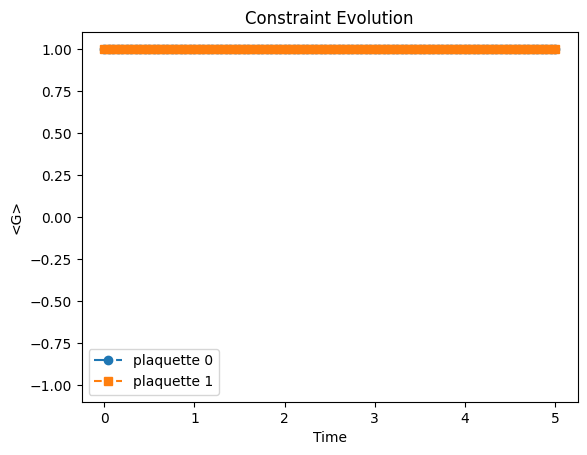

In [39]:
evol_res = {str(idx): [] for idx in range(len(plaquettes))}

for idx, plaquette in enumerate(plaquettes):
    for state in results:
        operator = G
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(np.abs(val))

for idx, i in enumerate(evol_res):
    plt.plot(temps, evol_res[i], label=f"plaquette {idx}", linestyle=line_styles[idx], marker=markers[idx])
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

### Numbers

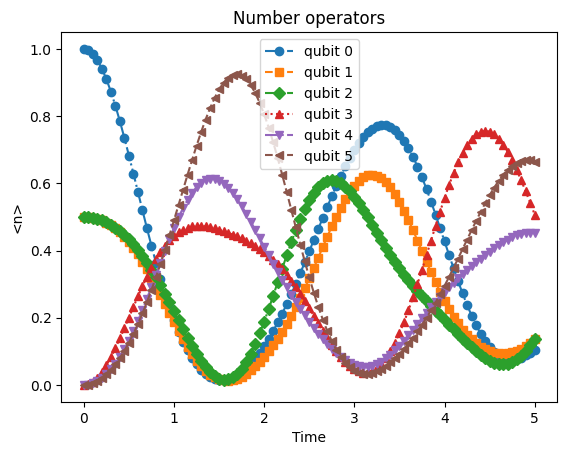

In [40]:
num_evol_res = []

for state in results:
    nums = compute_state_exp_numbers(qudits, state)
    num_evol_res.append(nums)
    
num_evol_res = np.array(num_evol_res)

for i in range(len(qudits.flatten())):
    plt.plot(temps, num_evol_res[:,i], label=f"qubit {i}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

In [41]:
np.sum(num_evol_res, axis=1)

array([2.        , 2.        , 1.99999997, 2.00000004, 2.00000002,
       2.        , 2.        , 1.99999995, 2.00000002, 1.99999998,
       1.99999995, 2.        , 2.00000002, 2.00000001, 1.99999997,
       1.99999993, 1.99999997, 1.99999995, 1.99999997, 2.00000002,
       1.99999994, 2.00000003, 2.00000001, 2.00000001, 1.99999996,
       2.00000002, 1.99999999, 2.00000004, 2.00000003, 1.99999998,
       2.00000004, 1.99999998, 2.00000003, 1.99999999, 1.99999998,
       1.99999998, 2.00000002, 1.99999998, 2.00000003, 2.00000003,
       2.00000001, 2.00000002, 2.00000001, 1.99999998, 1.99999997,
       1.99999998, 2.00000001, 1.99999999, 1.99999999, 2.        ,
       1.99999999, 1.99999994, 2.00000006, 2.        , 2.00000006,
       2.00000002, 2.        , 1.99999999, 2.00000002, 1.99999996,
       1.99999994, 2.00000002, 2.00000001, 2.        , 2.00000003,
       1.99999999, 2.00000001, 2.00000002, 1.99999998, 2.00000001,
       2.        , 2.00000003, 2.00000003, 1.99999999, 1.99999

### Hamiltonian

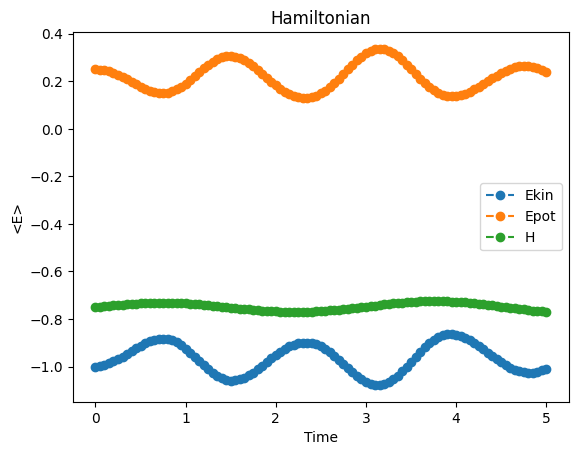

In [42]:
ekin = []
epot = []

for state in results:
    ham_k, ham_p = compute_state_exp_hamiltonian_tv(qudits, state, T, V)
    ekin.append(ham_k)
    epot.append(ham_p)

ekin = np.array(ekin)
epot = np.array(epot)

plt.plot(temps, ekin, "o--", label="Ekin")
plt.plot(temps, epot, "o--", label="Epot")
plt.plot(temps, ekin+epot, "o--", label="H")
    
plt.title("Hamiltonian")
plt.xlabel("Time")
plt.ylabel("<E>")
plt.legend()

In [43]:
# num_steps = 1
N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.4}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0	Pot=0.25	H=-0.75
t = 0.05		Ekin=-0.9972	Pot=0.2491	H=-0.7481
t = 0.1		Ekin=-0.9925	Pot=0.2463	H=-0.7463
t = 0.15		Ekin=-0.9862	Pot=0.2417	H=-0.7444
t = 0.2		Ekin=-0.9782	Pot=0.2355	H=-0.7427
t = 0.25		Ekin=-0.9687	Pot=0.2278	H=-0.741
t = 0.3		Ekin=-0.9582	Pot=0.2188	H=-0.7394
t = 0.35		Ekin=-0.9468	Pot=0.2089	H=-0.7378
t = 0.4		Ekin=-0.9349	Pot=0.1985	H=-0.7365
t = 0.45		Ekin=-0.9231	Pot=0.1879	H=-0.7352
t = 0.5		Ekin=-0.9118	Pot=0.1777	H=-0.7341
t = 0.55		Ekin=-0.9016	Pot=0.1685	H=-0.7332
t = 0.6		Ekin=-0.8931	Pot=0.1606	H=-0.7324
t = 0.65		Ekin=-0.8866	Pot=0.1547	H=-0.7319
t = 0.7		Ekin=-0.8828	Pot=0.1512	H=-0.7316
t = 0.75		Ekin=-0.8819	Pot=0.1504	H=-0.7315
t = 0.8		Ekin=-0.8842	Pot=0.1526	H=-0.7316
t = 0.85		Ekin=-0.8898	Pot=0.1579	H=-0.7319
t = 0.9		Ekin=-0.8986	Pot=0.1662	H=-0.7325
t = 0.95		Ekin=-0.9104	Pot=0.1772	H=-0.7333
t = 1.0		Ekin=-0.9248	Pot=0.1905	H=-0.7343
t = 1.05		Ekin=-0.9412	Pot=0.2057	H=-0.7355
t = 1.1		Ekin=-0.9589	Pot=0.222	H=-0.7369
t = 1.15	

In [44]:
temps

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25,
       3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 ,
       3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 ,
       4.95, 5.  ])

In [45]:
RESULTS = {
    "ham": (ekin+epot).tolist(),
    "ekin": ekin.tolist(),
    "epot": epot.tolist(),
    "nums": num_evol_res.tolist(),
    "temps": temps.tolist(),
}
with open("tv_model_data_sim.json", "w") as file:
    json.dump(RESULTS, file)

### Check if Trotterization is the problem

In [14]:
T = -1
V = 0.5

In [16]:
final_T = 0.4

nums_steps = [1, 2, 4, 8, 16, 32]


final_results_k = []
final_results_p = []
final_results_h = []
final_results_nums = []

for num_steps in nums_steps:
    print(f"Doing {num_steps} steps")
    
    dt = final_T / num_steps
    temps = np.arange(0, final_T+dt/2, dt)
    # results is a list of tuples, every tuple contains the circuit and the result shots
    results = evolve(qudits, temps, initial_circuit, T=T, V=V)

    ham_k, ham_p = compute_state_exp_hamiltonian_tv(qudits, results[-1], T, V)
    final_results_k.append(ham_k)
    final_results_p.append(ham_p)
    final_results_h.append(ham_k+ham_p)

    nums = compute_state_exp_numbers(qudits, results[-1])
    final_results_nums.append(nums)

Doing 1 steps
Doing 2 steps
Doing 4 steps
Doing 8 steps
Doing 16 steps
Doing 32 steps


Text(0.5, 1.0, 'Tot error on nums')

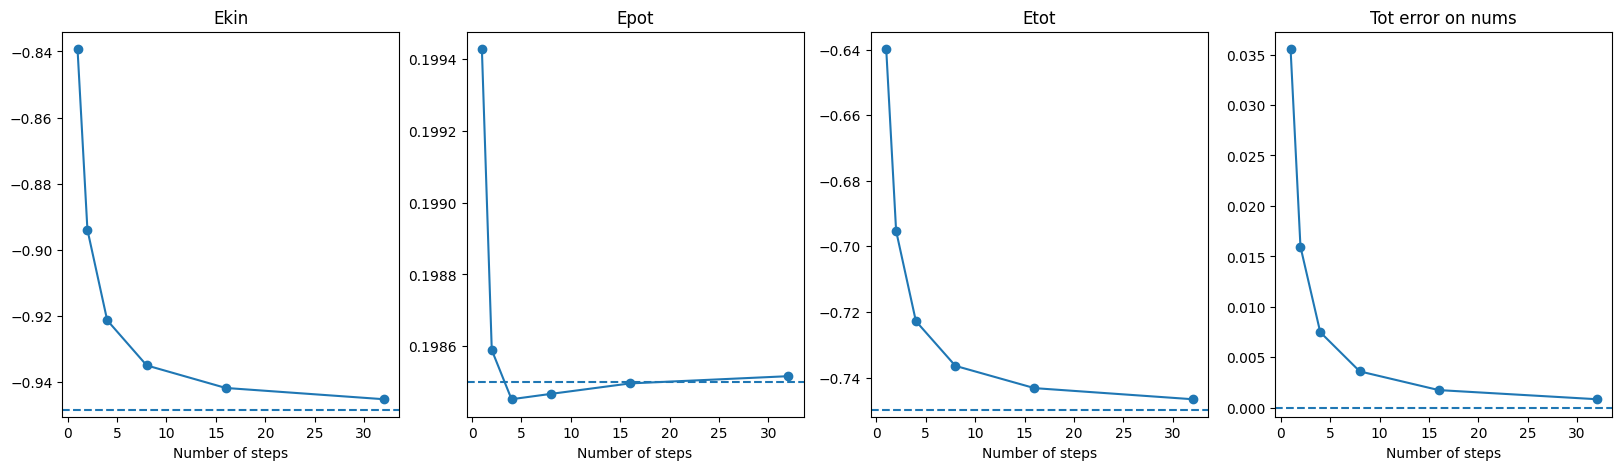

In [17]:
nk_val_k = -0.9485
nk_val_p = 0.1985
nk_val_h = -0.75
nk_numbers = np.array([0.7844, 0.4548, 0.458, 0.1399, 0.0829, 0.08])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

final_results_k = np.array(final_results_k)
final_results_p = np.array(final_results_p)

ax1.plot(nums_steps, final_results_k, "-o", label="Ekin")
ax1.axhline(nk_val_k, linestyle="--", label="NK kin")
ax1.set_xlabel("Number of steps")
ax1.set_title("Ekin")

ax2.plot(nums_steps, final_results_p, "-o", label="Epot")
ax2.axhline(nk_val_p, linestyle="--", label="NK pot")
ax2.set_xlabel("Number of steps")
ax2.set_title("Epot")

ax3.plot(nums_steps, final_results_h, "-o", label="Etot")
ax3.axhline(nk_val_h, linestyle="--", label="NK tot")
ax3.set_xlabel("Number of steps")
ax3.set_title("Etot")

num_error = [np.sum(np.abs(nk_numbers - i)) for i in final_results_nums]
ax4.plot(nums_steps, num_error, "-o", label="Etot")
ax4.axhline(0, linestyle="--", label="NK tot")
ax4.set_xlabel("Number of steps")
ax4.set_title("Tot error on nums")